# Aereal Drone Image Segmentation through U-net architecture

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import imageio.v2 as io
from PIL import Image
import os
import sys
import time
import random
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import segmentation_models_pytorch as smp

device= "cuda" if torch.cuda.is_available() else "cpu"

## Paths

In [17]:
dataset_path = r'E:\Datasets\drone_seg'
class_csv_path = os.path.join(dataset_path, r'class_dict_seg.csv')
original_images_path = os.path.join(dataset_path, r'dataset\semantic_drone_dataset\original_images')
rgb_masks_path = os.path.join(dataset_path, r'RGB_color_image_masks\RGB_color_image_masks')
semantic_masks_path = os.path.join(dataset_path, r'dataset\semantic_drone_dataset\label_images_semantic')

#Get the image and mask fullpaths
original_images = os.listdir(original_images_path)
original_images_fullpath = [os.path.join(original_images_path, image_path) for image_path in original_images]
rgb_masks = os.listdir(rgb_masks_path)
rgb_masks_fullpath = [os.path.join(rgb_masks_path, mask_path) for mask_path in rgb_masks]
semantic_masks = os.listdir(semantic_masks_path)
semantic_masks_fullpath = [os.path.join(semantic_masks_path, mask_path) for mask_path in semantic_masks]

## Plotting Functions

In [18]:
def print_colors_map(labels, suptitle='Colormap'):
    for i, (name, color) in enumerate(labels.items()):
        plt.subplot(6,4,i+1)
        color_image = np.array([[color,color,color,color]])
        plt.title(name)
        plt.imshow(color_image)
        plt.axis('off')
        plt.suptitle(suptitle)
    plt.show()

def plot_three_tensor_images(rgb, mask, pred, title_1, title_2, title_3):
    _,axs = plt.subplots(1,3, figsize=(20,10))
    axs[0].imshow((rgb[0].permute(1, 2, 0).numpy()* 255).astype('uint8'))
    axs[0].set_title(title_1)
    axs[0].axis('off')
    axs[1].imshow(mask[0].permute(1, 2, 0).numpy().astype('uint8'))
    axs[1].set_title(title_2)
    axs[1].axis('off')
    axs[2].imshow(pred[0].permute(1, 2, 0).numpy().astype('uint8'))
    axs[2].set_title(title_3)
    axs[2].axis('off')

def plot_single_image_and_mask(img,mask):
    _, axs = plt.subplots(1,2,figsize=(10,10))
    axs[0].imshow(img)
    axs[0].set_title('RGB image')
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    axs[0].axis('off')
    axs[1].axis('off')

def plot_three_images(img1, img2, img3, title_1, title_2, title_3):
    _,axs = plt.subplots(1,3, figsize=(20,10))
    axs[0].imshow(img1)
    axs[0].set_title(title_1)
    axs[0].axis('off')
    axs[1].imshow(img2)
    axs[1].set_title(title_2)
    axs[1].axis('off')
    axs[2].imshow(img3)
    axs[2].set_title(title_3)
    axs[2].axis('off')

def plot_image_and_mask(imgs_path, masks_path, semantic_path, n=1):
    for _ in range(n):
        i = np.random.randint(0, len(imgs_path))
        img = io.imread(imgs_path[i])
        rgb_mask = io.imread(masks_path[i])
        semantic_mask = io.imread(semantic_path[i])
        plot_three_images(img, rgb_mask, semantic_mask, 'RGB Image', 'RGB Mask', 'Grayscale Mask')
        print(f'RGB Image shape: {img.shape}, RGB Mask resized shape: {rgb_mask.shape}, Semantic Mask shape: {semantic_mask.shape}')

def plot_tensor_image(image, tl, figsize=(10,10)):
    image = image[0].permute(1, 2, 0).numpy()
    fig = plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.title(tl)
    plt.axis('off')
    plt.show()

## Dataset

Image shape: torch.Size([1, 3, 736, 960]), Mask shape: torch.Size([1, 1, 736, 960]), Mask values: [0 1]


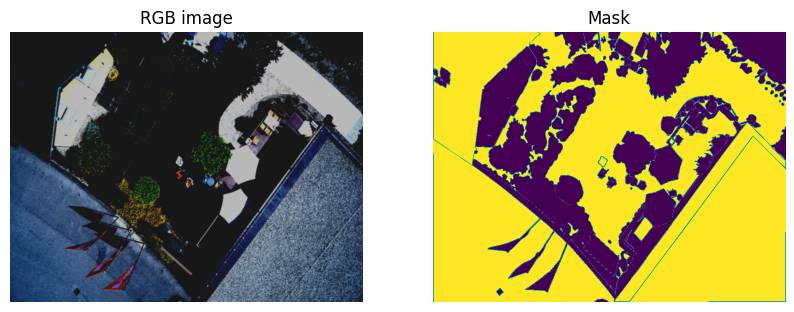

In [20]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, mask_paths, t=False, group_labels=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.t = t #Apply transforms or not
        #self.degrees = 180 #Angle for random rotation
        self.resize_dim = (736,960)#(224,224)
        self.Color_transform = torchvision.transforms.ColorJitter()
        self.group_labels = group_labels #Group labels into 5 new classes

        self.mean = [0.485, 0.456, 0.406] #Imagenet mean ans std
        self.std = [0.229, 0.224, 0.225]

    def transform(self, image, mask):
        # Resize
        #resize = transforms.Resize(size=self.resize_dim, antialias=True)
        #image = resize(image)
        #mask = resize(mask)

        # Random crop
        #i, j, h, w = transforms.RandomCrop.get_params(
        #    image, output_size=(512, 512))
        #image = transforms.functional.crop(image, i, j, h, w)
        #mask = transforms.functional.crop(mask, i, j, h, w)

        #Normalizing the image
        image = transforms.functional.normalize(image, self.mean, self.std)

        # Random horizontal flipping
        if np.random.random() > 0.5:
            image = transforms.functional.hflip(image)
            mask = transforms.functional.hflip(mask)

        # Random vertical flipping
        if np.random.random() > 0.5:
            image = transforms.functional.vflip(image)
            mask = transforms.functional.vflip(mask)
        
        # Random rotation
        #if np.random.random() > 0.5:
        #    angle = np.random.uniform(-self.degrees, self.degrees)
        #    image =  transforms.functional.rotate(image, angle) 
        #    mask = transforms.functional.rotate(mask, angle)
        
        #Randomly change the brightness, contrast, saturation and hue of an image
        if np.random.random() > 0.5:
            image = transforms.functional.adjust_brightness(image, np.random.random())
        if np.random.random() > 0.5:
            image = transforms.functional.adjust_saturation(image, np.random.random())
        if np.random.random() > 0.5:
            image = transforms.functional.adjust_contrast(image, np.random.random())
        
        #Randomly add Guassian Blur
        if np.random.random() > 0.5:
            image = transforms.functional.gaussian_blur(image, kernel_size = (3,3), sigma = None)
        
        return image, mask

    def __getitem__(self, idx):
        image = torchvision.io.read_image(self.image_paths[idx]).float() / 255.0
        mask = torchvision.io.read_image(self.mask_paths[idx]).long()
        
        #resize = transforms.Resize(size=self.resize_dim, antialias=True)
        image = transforms.functional.resize(image, self.resize_dim, antialias=True)
        mask = transforms.functional.resize(mask, self.resize_dim, antialias=True)

        if self.group_labels:
            labels_grouped = {
                0: {0, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23}, # 0:[96,115,247] - 'no-landable zone'
	            1: {1, 2, 3, 4, 9, 21} #1:[218,120,216] - 'landable zone'
            }
            reverse_mapping = {}
            for new_class, old_classes in labels_grouped.items():
                for old_class in old_classes:
                    reverse_mapping[old_class] = new_class

            mask = np.vectorize(reverse_mapping.get)(mask)
            mask = torch.from_numpy(mask).long()

        if self.t:
            x, y = self.transform(image, mask)
            return x, y
        else:
            return image, mask

    def __len__(self):
        return len(self.image_paths)

# Dataset and Dataloader
dataset = CustomDataset(original_images_fullpath,
                        semantic_masks_fullpath,
                        t=True,
                        group_labels=True)

dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Iterar sobre el dataloader
images, masks = next(iter(dataloader))
print(f'Image shape: {images.shape}, Mask shape: {masks.shape}, Mask values: {np.unique(masks)}')
images = (images[0].permute(1, 2, 0).numpy()* 255).astype('uint8')
plot_single_image_and_mask(images, masks[0].permute(1, 2, 0).numpy())

In [21]:
image_mask_paths = [(image_path, mask_path) for image_path, mask_path in zip(original_images_fullpath, semantic_masks_fullpath)]
random.shuffle(image_mask_paths)

TRAIN_SPLIT = 0.75
VALID_SPLIT = 0.2

train_paths = image_mask_paths[:int(len(image_mask_paths)*TRAIN_SPLIT)]
valid_paths = image_mask_paths[int(len(train_paths)):int(len(train_paths) + len(image_mask_paths)*VALID_SPLIT)]
test_paths = image_mask_paths[int(len(train_paths) + len(valid_paths)):]

print(f'Train: {len(train_paths)} images, Valid: {len(valid_paths)} images, Test: {len(test_paths)} images')

train_dataset = CustomDataset(image_paths=[image_path for image_path,_ in train_paths],
                              mask_paths=[mask_path for _,mask_path in train_paths],
                              t=True, group_labels=True)

valid_dataset = CustomDataset(image_paths=[image_path for image_path,_ in valid_paths],
                              mask_paths=[mask_path for _,mask_path in valid_paths],
                              t=False, group_labels=True)

test_dataset = CustomDataset(image_paths=[image_path for image_path,_ in test_paths],
                             mask_paths=[mask_path for _,mask_path in test_paths],
                             t=False, group_labels=True)

Train: 300 images, Valid: 80 images, Test: 20 images


## Pretrained Model

In [22]:
num_classes = 2
model = smp.Unet('efficientnet-b0', encoder_weights='imagenet', classes=num_classes, activation=None)
model.to(device)
summary(model, (3,736,960))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 737, 961]               0
Conv2dStaticSamePadding-2         [-1, 32, 368, 480]             864
       BatchNorm2d-3         [-1, 32, 368, 480]              64
MemoryEfficientSwish-4         [-1, 32, 368, 480]               0
         ZeroPad2d-5         [-1, 32, 370, 482]               0
Conv2dStaticSamePadding-6         [-1, 32, 368, 480]             288
       BatchNorm2d-7         [-1, 32, 368, 480]              64
MemoryEfficientSwish-8         [-1, 32, 368, 480]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 32, 1, 1]             288
         I

## Training process

In [9]:
n_epochs = 50
epoch_number = 0
best_viou = 0.0
batch_size = 4
lr = 1e-3

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

writer_path = r'.\reporters\Reporter_smp_2classes_960x736.txt'
def parameters_writer(parameters_list, save_path):
    with open(save_path, 'a+') as f:
        for param in parameters_list:
            f.write(f'{param} ')
        f.write('\n')

#criterion = nn.CrossEntropyLoss()
criterion = smp.losses.DiceLoss(mode='multiclass').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

############################## TRAIN LOOP #############################################

def train_one_epoch(epoch_index):
    running_log = {"loss":0.0, "iou":0.0, "f1score":0.0, "f2score":0.0, "accuracy":0.0, "recall":0.0, "precision":0.0}
    log = running_log

    for j, data in enumerate(train_dataloader):

        imgs, masks = data
        imgs = imgs.to(device)
        masks = masks.to(device)
        
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        #Get network outputs
        outputs = model(imgs)

        # Compute the loss and its gradients
        loss = criterion(outputs, masks)
        #loss = criterion(outputs, torch.squeeze(masks, dim=1)) #For CE Loss
        #print(loss)

        loss.backward()
        
        # Adjust learning weights
        optimizer.step()

        #scheduler.step() 

        # Gather data and report
        tp, fp, fn, tn = smp.metrics.get_stats(torch.argmax(outputs, 1).unsqueeze(1), masks, mode='multiclass', num_classes = num_classes)
        iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro-imagewise")
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro")
        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")
        precision= smp.metrics.precision(tp, fp, fn, tn, reduction="micro-imagewise", class_weights=None, zero_division=1.0)
        
        running_log['loss'] += loss.item()
        running_log['iou'] += iou.item()
        running_log['f1score'] += f1_score.item()
        running_log['f2score'] += f2_score.item()
        running_log['accuracy'] += accuracy.item()
        running_log['recall'] += recall.item()
        running_log['precision'] += precision.item()

    log['loss'] = running_log['loss'] / (j + 1)
    log['iou'] = running_log['iou'] / (j + 1)
    log['f1score'] = running_log['f1score'] / (j + 1)
    log['f2score'] = running_log['f2score'] / (j + 1)
    log['accuracy'] = running_log['accuracy'] / (j + 1)
    log['recall'] = running_log['recall'] / (j + 1)
    log['precision'] = running_log['precision'] / (j + 1)      
        
    return log

for epoch in range(n_epochs):
    inicio = time.time()
    train_parameters = []

    model.train()
    log = train_one_epoch(epoch)

    running_vlog = {"loss":0.0, "iou":0.0, "f1score":0.0, "f2score":0.0, "accuracy":0.0, "recall":0.0, "precision":0.0}
    vlog = running_vlog
    
    model.eval()

    with torch.no_grad():
        for k, vdata in enumerate(valid_dataloader):
            vimgs, vmasks = vdata
            vimgs, vmasks = vimgs.to(device), vmasks.to(device)
            
            voutputs = model(vimgs)               

            vloss = criterion(voutputs, vmasks)
            #vloss = criterion(voutputs, torch.squeeze(vmasks, dim=1)) #For CE Loss

            # Gather data and report
            tp, fp, fn, tn = smp.metrics.get_stats(torch.argmax(voutputs, 1).unsqueeze(1), vmasks, mode='multiclass', num_classes = num_classes)
            viou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro-imagewise")
            f1_vscore = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
            f2_vscore = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro")
            vaccuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
            vrecall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")
            vprecision= smp.metrics.precision(tp, fp, fn, tn, reduction="micro-imagewise", class_weights=None, zero_division=1.0)
            
            running_vlog['loss'] += vloss.item()
            running_vlog['iou'] += viou.item()
            running_vlog['f1score'] += f1_vscore.item()
            running_vlog['f2score'] += f2_vscore.item()
            running_vlog['accuracy'] += vaccuracy.item()
            running_vlog['recall'] += vrecall.item()
            running_vlog['precision'] += vprecision.item()

        vlog['loss'] = running_vlog['loss'] / (k + 1)
        vlog['iou'] = running_vlog['iou'] / (k + 1)
        vlog['f1score'] = running_vlog['f1score'] / (k + 1)
        vlog['f2score'] = running_vlog['f2score'] / (k + 1)
        vlog['accuracy'] = running_vlog['accuracy'] / (k + 1)
        vlog['recall'] = running_vlog['recall'] / (k + 1)
        vlog['precision'] = running_vlog['precision'] / (k + 1) 

    fin = time.time()

    avg_loss, avg_acc, avg_iou = log['loss'], log['accuracy'], log['iou']
    avg_vloss, avg_vacc, avg_viou = vlog['loss'], vlog['accuracy'], vlog['iou']

    print(f'Epoch {epoch_number + 1} - Train_loss: {np.round(avg_loss,4)} - Valid_loss: {np.round(avg_vloss,4)} - Train_acc: {np.round(avg_acc,4)} - Valid_acc: {np.round(avg_vacc,4)} - Train_iou: {np.round(avg_iou,4)} - Valid_iou: {np.round(avg_viou,4)} - Tiempo: {(fin-inicio)/60.0} minutos - Estimado: {((n_epochs-epoch_number-1)*(fin-inicio))/60.0} minutos')
    
    # Track best performance, and save the model's state
    if avg_viou > best_viou:
        best_viou = avg_viou
        model_path = rf'.\models\best_Unet_seg_smp_2classes_960x736.pth'
        torch.save(model.state_dict(), model_path)

    train_parameters.append(f'Epoch {epoch_number + 1} - Train_loss: {np.round(avg_loss,4)} - Valid_loss: {np.round(avg_vloss,4)} - Train_acc: {np.round(avg_acc,4)} - Valid_acc: {np.round(avg_vacc,4)} - Train_iou: {np.round(avg_iou,4)} - Valid_iou: {np.round(avg_viou,4)}')
    parameters_writer(train_parameters, writer_path)

    epoch_number += 1

model_path = rf'.\models\last_Unet_seg_smp_2classes_960x736.pth'
torch.save(model.state_dict(), model_path)

Epoch 1 - Train_loss: 0.3465 - Valid_loss: 0.2957 - Train_acc: 0.7382 - Valid_acc: 0.7499 - Train_iou: 0.5154 - Valid_iou: 0.5421 - Tiempo: 5.051169613997142 minutos - Estimado: 247.50731108585993 minutos
Epoch 2 - Train_loss: 0.2725 - Valid_loss: 0.4002 - Train_acc: 0.8 - Valid_acc: 0.7802 - Train_iou: 0.5822 - Valid_iou: 0.4803 - Tiempo: 4.809389483928681 minutos - Estimado: 230.85069522857665 minutos
Epoch 3 - Train_loss: 0.2584 - Valid_loss: 0.2513 - Train_acc: 0.8061 - Valid_acc: 0.8256 - Train_iou: 0.5986 - Valid_iou: 0.6015 - Tiempo: 5.465845175584158 minutos - Estimado: 256.8947232524554 minutos
Epoch 4 - Train_loss: 0.2475 - Valid_loss: 0.222 - Train_acc: 0.8174 - Valid_acc: 0.8437 - Train_iou: 0.6062 - Valid_iou: 0.634 - Tiempo: 4.698553884029389 minutos - Estimado: 216.13347866535187 minutos
Epoch 5 - Train_loss: 0.232 - Valid_loss: 0.2209 - Train_acc: 0.828 - Valid_acc: 0.8509 - Train_iou: 0.6284 - Valid_iou: 0.6472 - Tiempo: 4.117153759797414 minutos - Estimado: 185.271919

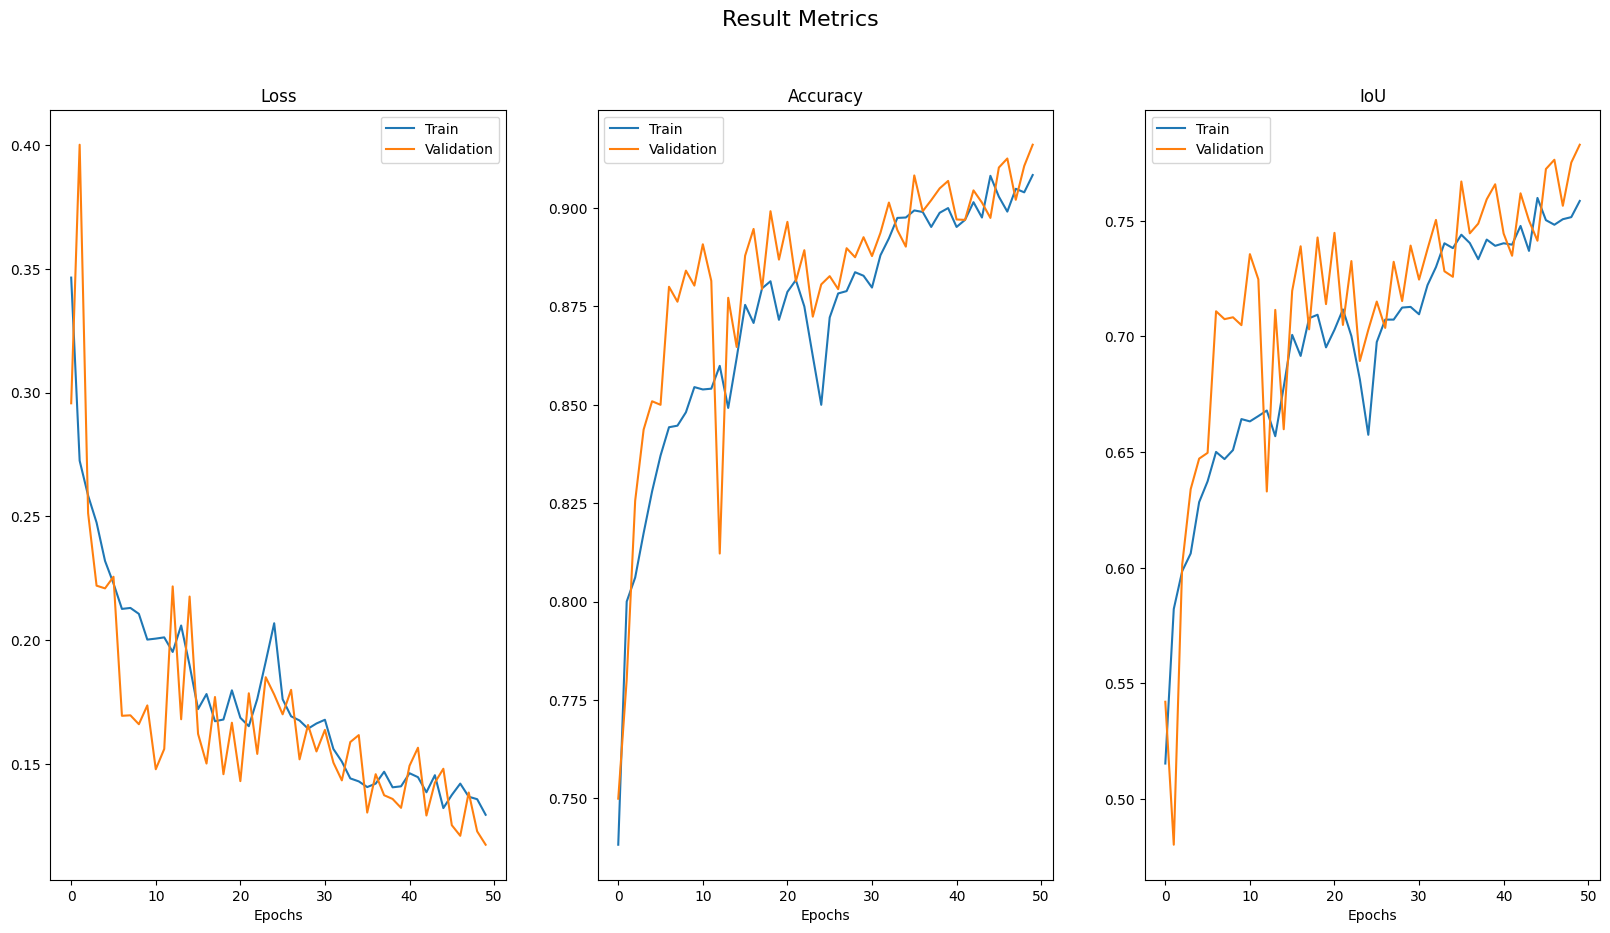

In [10]:
def plot_metrics(reporter_path):
    epochs, tloss, vloss, tacc, vacc, tiou, viou = [], [], [], [], [], [], []
    with open(reporter_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            metrics = line.split(sep='-')
            #epochs.append(metrics[0].split(sep=' ')[1])
            tloss.append(float(metrics[1].split(sep=':')[1][1:-1]))
            vloss.append(float(metrics[2].split(sep=':')[1][1:-1]))
            tacc.append(float(metrics[3].split(sep=':')[1][1:-1]))
            vacc.append(float(metrics[4].split(sep=':')[1][1:-1]))
            tiou.append(float(metrics[5].split(sep=':')[1][1:-1]))
            viou.append(float(metrics[6].split(sep=':')[1][1:-1]))

    fig, axs = plt.subplots(1,3,figsize=(20,10))
    axs[0].plot(tloss, label='Train')
    axs[0].plot(vloss, label='Validation')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].legend()

    axs[1].plot(tacc, label='Train')
    axs[1].plot(vacc, label='Validation')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].legend()

    axs[2].plot(tiou, label= 'Train')
    axs[2].plot(viou, label= 'Validation')
    axs[2].set_title('IoU')
    axs[2].set_xlabel('Epochs')
    axs[2].legend()

    plt.suptitle('Result Metrics', fontsize=16)

reporter = r'.\reporters\Reporter_smp_2classes_960x736.txt'
plot_metrics(reporter)

## Test trained net

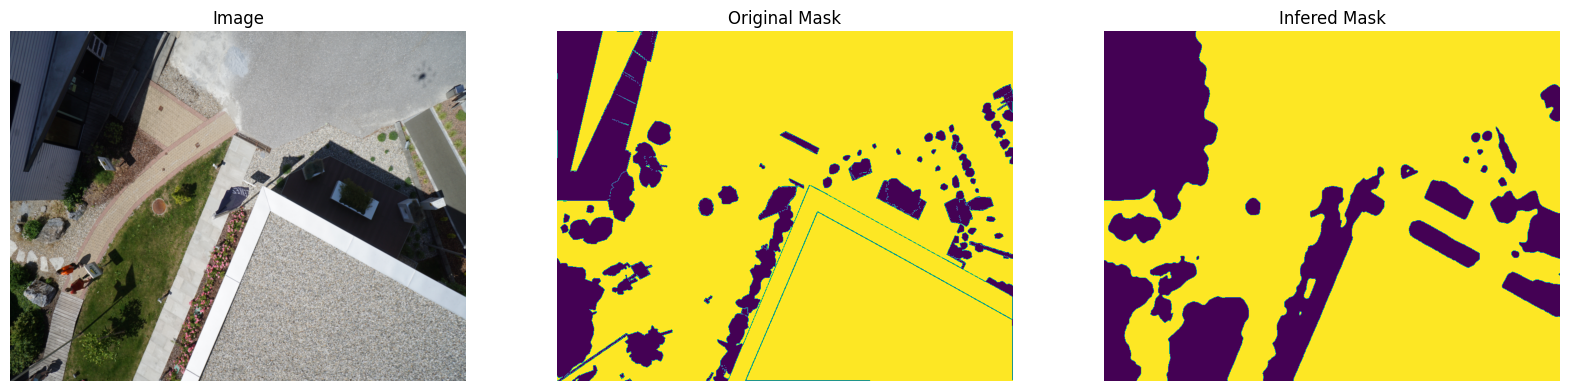

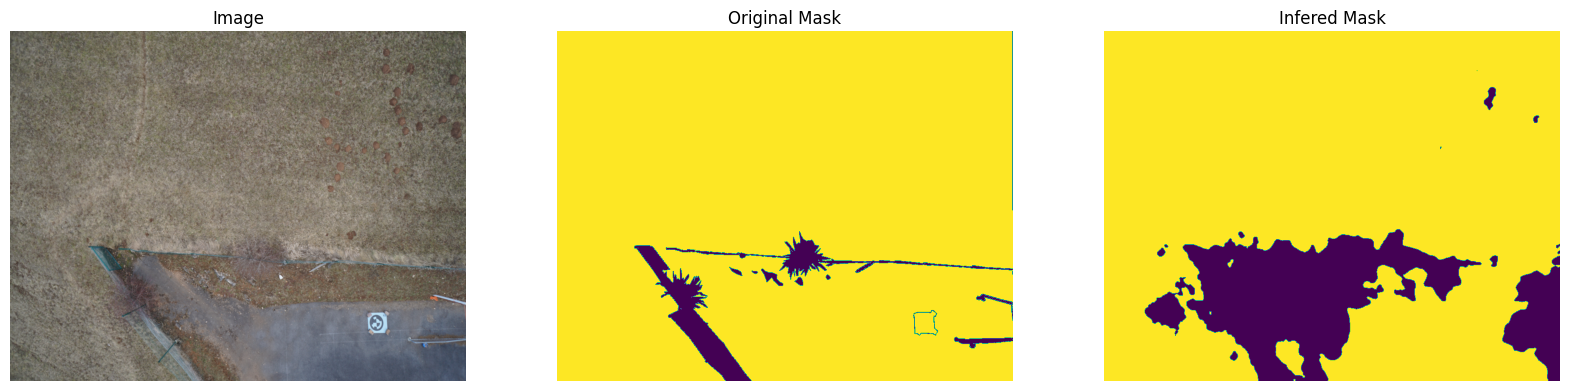

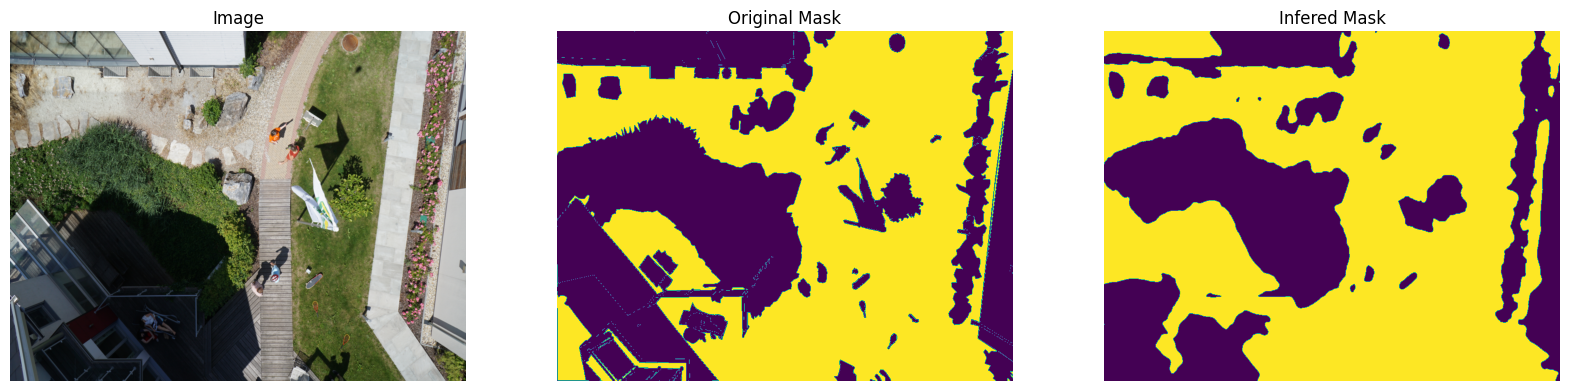

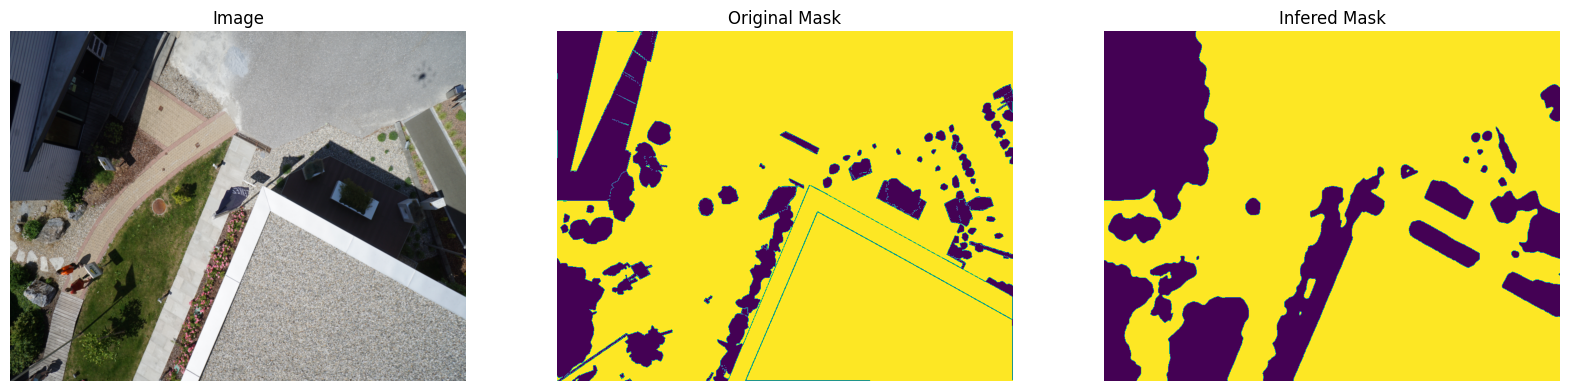

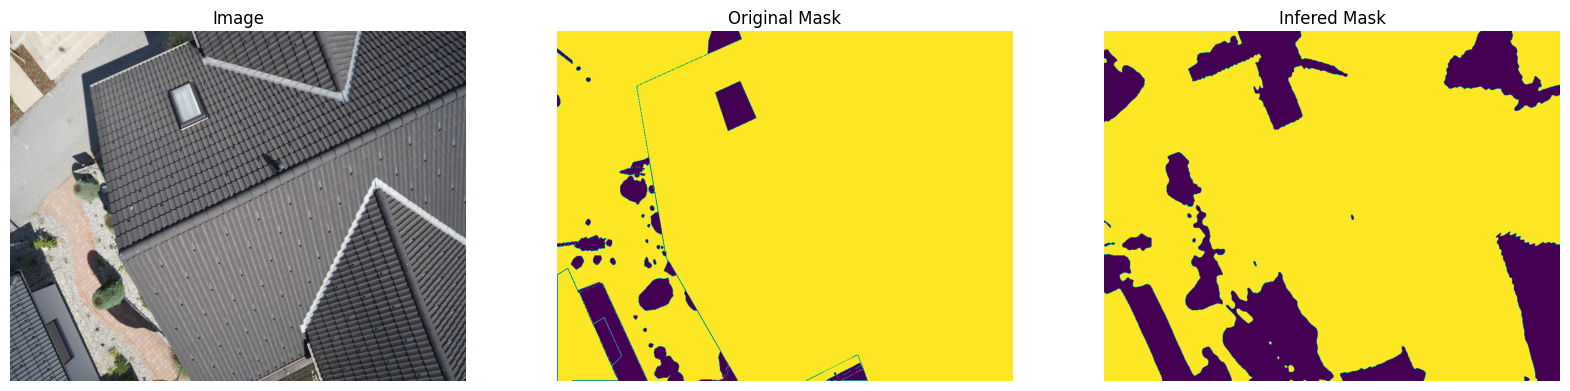

In [23]:
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)
model.load_state_dict(torch.load(r'.\models\best_Unet_seg_smp_2classes_960x736.pth'))

for _ in range(5):
    img, mask = next(iter(test_dataloader))
    img = img.to(device)
    out = model(img)

    _,mask_out=torch.max(out,dim=1)
    mask_out_ = mask_out.unsqueeze(1)

    img = img.detach().cpu()
    mask = mask.detach().cpu()
    mask_out = mask_out_.detach().cpu()
    plot_three_tensor_images(img, mask, mask_out, 'Image', 'Original Mask', 'Infered Mask')


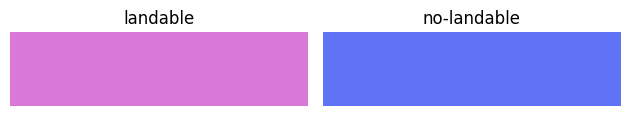

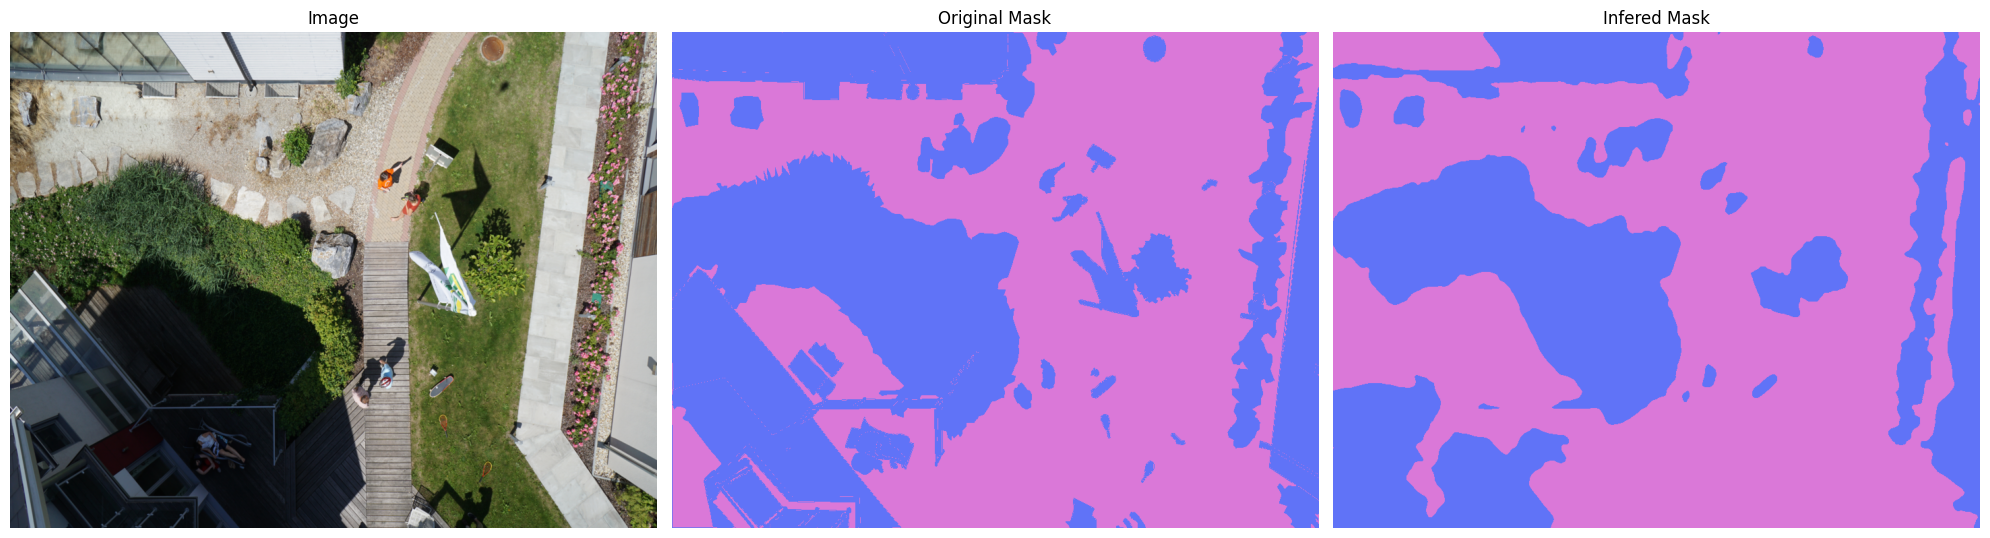

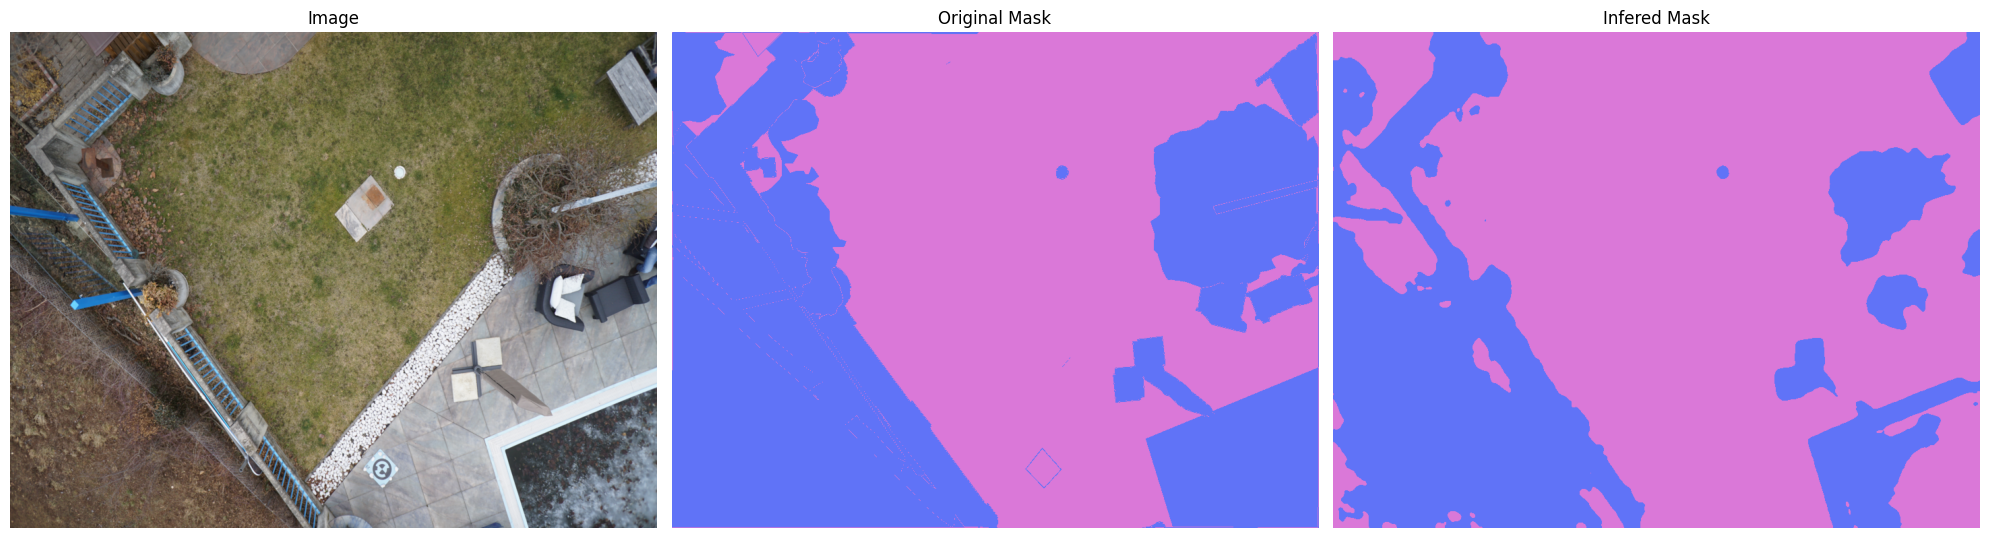

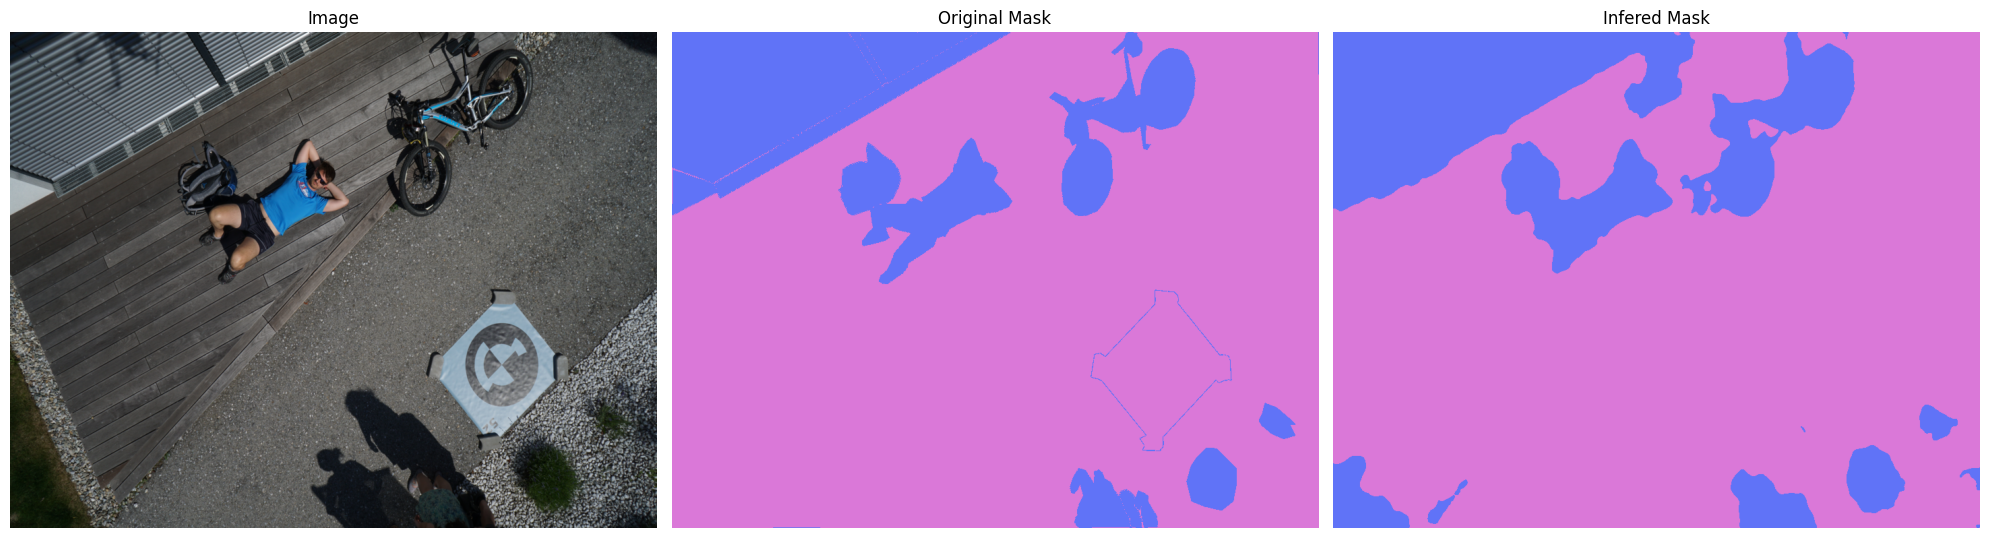

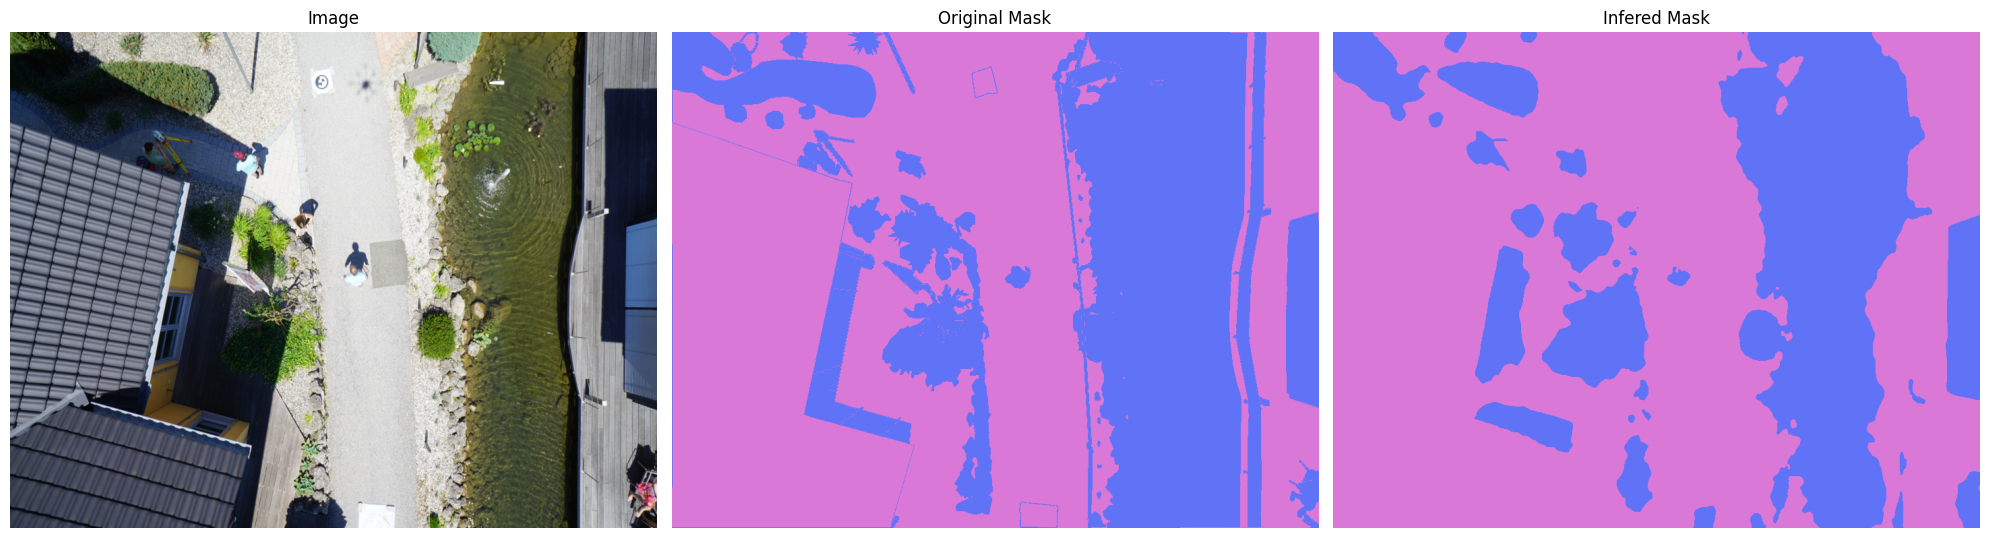

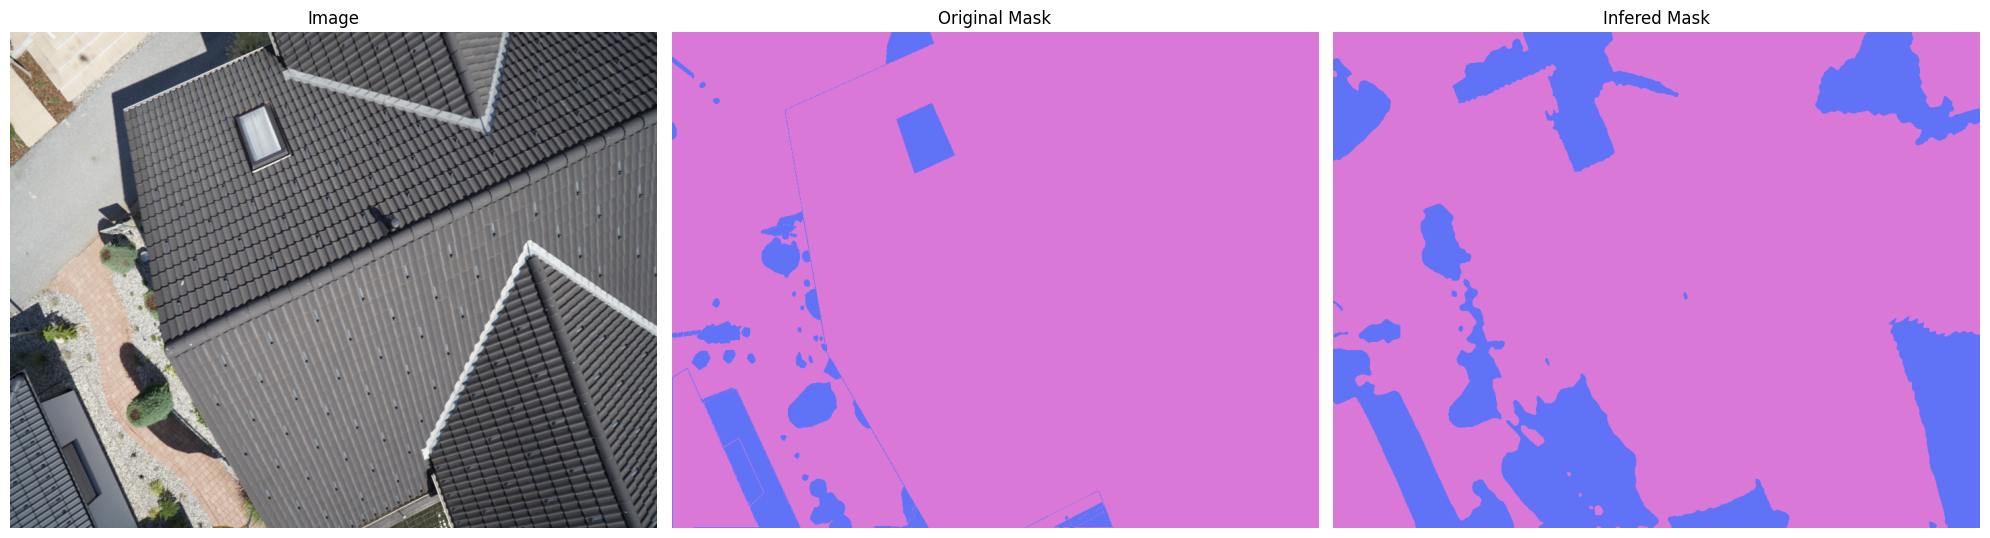

In [32]:
classes = 2
if classes == 2:
    palette = [[96,115,247], [218,120,216]]
    pal = [value for color in palette for value in color]
elif classes == 23:   
    labels = pd.read_csv(class_csv_path)
    palette = labels[[' r', ' g', ' b']].values.tolist()
    pal = [value for color in palette for value in color]

labels_color_grouped = {'landable':(218,120,216), 'no-landable':(96,115,247)}
for i, (name, color) in enumerate(labels_color_grouped.items()):
    plt.subplot(1,2,i+1)
    color_image = np.array([[color,color,color,color]])
    plt.title(name)
    plt.imshow(color_image)
    plt.axis('off')
    plt.tight_layout()
plt.show()

for _ in range(5):
    img, mask = next(iter(test_dataloader))

    cols = ['Image', 'Original Mask', 'Infered Mask']
    fig, axs = plt.subplots(1, 3, figsize=(20, 30), tight_layout=True)

    out = model(img.to(device))
    _,pred=torch.max(out,dim=1)

    img = (img.detach().cpu().numpy() * 255).astype('uint8')
    pred = pred.detach().cpu().numpy().astype('uint8')
    mask = mask.detach().cpu().numpy().astype('uint8')

    mask = Image.fromarray(mask[0,0]).convert('P')
    pred = Image.fromarray(pred[0]).convert('P')

    mask.putpalette(pal)
    pred.putpalette(pal)

    axs[0].imshow(img[0].transpose(1, 2, 0))
    axs[0].set_axis_off()
    axs[0].set_title(cols[0])
    axs[1].imshow(mask)
    axs[1].set_axis_off()
    axs[1].set_title(cols[1])
    axs[2].imshow(pred)
    axs[2].set_axis_off()
    axs[2].set_title(cols[2])

    plt.show()